In [1]:
!pip install torch torchvision scikit-learn matplotlib ultralytics umap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.1 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=d90c

In [2]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image
import xml.etree.ElementTree as ET
import shutil, yaml, math, gc, contextlib
from pathlib import Path
from PIL import Image
import os

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


In [3]:
# =======================================================================
# 2. Paths
# -----------------------------------------------------------------------
BASE  = Path("/kaggle/input/bangladesh-traffic/Bangladeshi Traffic Flow Dataset/Annotated Images")
WORK  = Path("/kaggle/working/traffic_ssl_vit")
SPLIT = WORK / "0_yolo_split"
SSL_W = WORK / "simclr_backbone.pth"
DATA  = WORK / "data_traffic.yaml"
WORK.mkdir(parents=True, exist_ok=True)

# =======================================================================
# 3. Pascal VOC → YOLO conversion + automatic dataset split
# -----------------------------------------------------------------------
import random

def voc2yolo(xml_file, classes, out_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)

    with open(out_file, "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)

            xmlbox = obj.find("bndbox")
            xmin, ymin = float(xmlbox.find("xmin").text), float(xmlbox.find("ymin").text)
            xmax, ymax = float(xmlbox.find("xmax").text), float(xmlbox.find("ymax").text)

            # Convert to YOLO format
            x = (xmin + xmax) / 2.0 / w
            y = (ymin + ymax) / 2.0 / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            f.write(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

def create_split(all_files, ratios=(0.7,0.2,0.1)):
    n = len(all_files)
    n_train = int(ratios[0]*n)
    n_val   = int(ratios[1]*n)
    random.shuffle(all_files)
    return (all_files[:n_train],
            all_files[n_train:n_train+n_val],
            all_files[n_train+n_val:])

def convert_and_split(base_dir, classes, ratios=(0.7,0.2,0.1)):
    # Wipe any old split to avoid stale empty folders
    if SPLIT.exists():
        shutil.rmtree(SPLIT)

    # Collect all image + xml pairs (support many extensions)
    all_pairs = []
    exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]
    for ext in exts:
        for img_file in Path(base_dir).rglob(ext):
            xml_file = img_file.with_suffix(".xml")
            if xml_file.exists():
                all_pairs.append((img_file, xml_file))
    print(f"Found {len(all_pairs)} annotated images total.")

    if len(all_pairs) == 0:
        raise RuntimeError("❌ No image/xml pairs found. Check dataset path & extensions.")

    # Split into train/val/test
    train, val, test = create_split(all_pairs, ratios)
    splits = {"train":train, "valid":val, "test":test}

    for split_name, files in splits.items():
        out_im, out_lb = SPLIT/split_name/"images", SPLIT/split_name/"labels"
        out_im.mkdir(parents=True, exist_ok=True)
        out_lb.mkdir(parents=True, exist_ok=True)

        for img_file, xml_file in files:
            shutil.copy(img_file, out_im/img_file.name)
            voc2yolo(xml_file, classes, out_lb/f"{img_file.stem}.txt")
        print(f"{split_name}: {len(files)} images")

# Classes in your dataset
CLASSES = ["Rickshaw","Bus","Truck","Bike","Mini-truck","People","Car","CNG","Cycle"]

print("➤ Converting Pascal VOC → YOLO with auto split …")
convert_and_split(BASE, CLASSES, ratios=(0.7,0.2,0.1))

DATA.write_text(yaml.dump({
    "path": str(SPLIT),
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(CLASSES),
    "names": CLASSES
}))
print("✓ YOLO split ready.")

➤ Converting Pascal VOC → YOLO with auto split …
Found 23678 annotated images total.
train: 16574 images
valid: 4735 images
test: 2369 images
✓ YOLO split ready.


In [4]:
# ================================================================
# 4. Two-view dataset  (robust to mixed extensions)
# ================================================================
class TwoView(Dataset):
    SUPP = ('*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG')
    def __init__(self, roots, tfm):
        self.files = []
        for r in roots:
            pr = Path(r)
            for pattern in self.SUPP:
                self.files.extend(pr.rglob(pattern))
        if not self.files:
            raise RuntimeError(f"No images found under {roots}")
        self.tfm = tfm
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        return self.tfm(img), self.tfm(img)

augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(),
])


In [5]:
# ================================================================
# 5. NT-Xent loss (FP16-safe)
# ================================================================
def nt_xent(z1, z2, tau=0.2):
    B = z1.size(0)
    z1 = z1.float(); z2 = z2.float()
    z = torch.cat([z1, z2], 0)           # 2B × d
    sim = z @ z.T / tau
    idx = torch.arange(2*B, device=z.device)
    sim[idx, idx] = -1e4                 # large negative within fp16 range
    pos = torch.cat([(z1*z2).sum(1)/tau]*2, 0)
    return (-pos + torch.logsumexp(sim, 1)).mean()

In [6]:
# ================================================================
# 6. SimCLR pre-training (AMP, batch 32, num_workers = 0)
# ================================================================
SSL_EPOCHS, SSL_BATCH = 25, 32

if SSL_W.exists():
    print("✓ SimCLR backbone cached – skipping pre-train")
else:
    print("\n🔄  SimCLR pre-training …")

    backbone = YOLO("yolov10s.yaml").model.model[0].to(device)
    opt     = torch.optim.AdamW(backbone.parameters(), lr=1e-3)
    scaler  = torch.cuda.amp.GradScaler()

    ds = TwoView([SPLIT/"train/images", SPLIT/"valid/images"], augment)
    dl = DataLoader(ds, batch_size=SSL_BATCH, shuffle=True,
                    num_workers=2, pin_memory=True, drop_last=True)   # ← workers = 0

    for ep in range(SSL_EPOCHS):
        backbone.train(); tot = 0
        for v1, v2 in tqdm(dl, leave=False, desc=f"SSL {ep+1}/{SSL_EPOCHS}"):
            v1, v2 = v1.to(device), v2.to(device)
            with torch.cuda.amp.autocast():
                f1 = backbone(v1)[-1].flatten(1)
                f2 = backbone(v2)[-1].flatten(1)
                z1 = F.normalize(f1, dim=1)
                z2 = F.normalize(f2, dim=1)
                loss = nt_xent(z1, z2)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); opt.zero_grad()
            tot += loss.item()
        print(f"Epoch {ep+1}/{SSL_EPOCHS}  loss={tot/len(dl):.4f}")

    torch.save(backbone.state_dict(), SSL_W)
    del backbone, dl, ds; gc.collect(); torch.cuda.empty_cache()
    print("✓ Saved backbone →", SSL_W)


🔄  SimCLR pre-training …


/tmp/ipykernel_19/2435931207.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = torch.cuda.amp.GradScaler()


SSL 1/25:   0%|          | 0/665 [00:00<?, ?it/s]

/tmp/ipykernel_19/2435931207.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/25  loss=3.7370


SSL 2/25:   0%|          | 0/665 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2/25  loss=3.0934


SSL 3/25:   0%|          | 0/665 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3/25  loss=2.9864


SSL 4/25:   0%|          | 0/665 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 4/25  loss=2.8880


SSL 5/25:   0%|          | 0/665 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 5/25  loss=2.8624


SSL 6/25:   0%|          | 0/665 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

              ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Epoch 6/25  loss=2.8025


SSL 7/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 7/25  loss=2.7985


SSL 8/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 8/25  loss=2.7963


SSL 9/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 9/25  loss=2.7633


SSL 10/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 10/25  loss=2.7544


SSL 11/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 11/25  loss=2.7319


SSL 12/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 12/25  loss=2.7309


SSL 13/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 13/25  loss=2.7305


SSL 14/25:   0%|          | 0/665 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 14/25  loss=2.7190


SSL 15/25:   0%|          | 0/665 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 15/25  loss=2.7270


SSL 16/25:   0%|          | 0/665 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 16/25  loss=2.7074


SSL 17/25:   0%|          | 0/665 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 17/25  loss=2.7045


SSL 18/25:   0%|          | 0/665 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e171e96d6c0>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive(): 
         ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3

Epoch 18/25  loss=2.6996


SSL 19/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 19/25  loss=2.7116


SSL 20/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 20/25  loss=2.6899


SSL 21/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 21/25  loss=2.6978


SSL 22/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 22/25  loss=2.6859


SSL 23/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 23/25  loss=2.6781


SSL 24/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 24/25  loss=2.6805


SSL 25/25:   0%|          | 0/665 [00:00<?, ?it/s]

Epoch 25/25  loss=2.6740
✓ Saved backbone → /kaggle/working/traffic_ssl_vit/simclr_backbone.pth


In [7]:
# ================================================================
# 7. Fine-tune YOLOv8-s detector
# ================================================================
print("\n🚀 Fine-tuning YOLOv10s")
det = YOLO("yolov10s.yaml")
det.model.model[0].load_state_dict(torch.load(SSL_W), strict=False)
det.train(data=str(DATA), epochs=25, imgsz=640, batch=8,
          project=str(WORK), name="simclr_yolov10s", device=0)




🚀 Fine-tuning YOLOv10s
Ultralytics 8.3.187 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_ssl_vit/data_traffic.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=simclr_yolov10s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=1

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46495      0.635      0.651       0.69      0.462
              Rickshaw       3880      11982      0.728      0.868      0.884        0.6
                   Bus       3868      10416      0.725      0.844      0.857       0.61
                 Truck        267        285      0.446      0.212      0.288       0.22
                  Bike       2127       3210      0.691      0.798      0.812      0.486
                People       2903       7661      0.703      0.794      0.826       0.51
                   Car       4261      12793      0.776      0.891      0.919      0.676
                 Cycle        145        148      0.378      0.149      0.243      0.133
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/traffic_ssl_vit/simclr_yolov10s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 5, 6, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e137e712210>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [8]:
# ================================================================
# 8. Evaluate
# ================================================================

print("\n📊  Evaluating …")
metrics = det.val(data=str(DATA), imgsz=640, batch=4, device=0)
print("\n🏁  Final metrics:", metrics)


📊  Evaluating …
Ultralytics 8.3.187 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,221,483 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1347.6±526.9 MB/s, size: 68.0 KB)
val: Scanning /kaggle/working/traffic_ssl_vit/0_yolo_split/valid/labels.cache... 4735 images, 13 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4735/4735 7915515.9it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1184/1184 24.3it/s 48.7s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46495      0.636      0.651       0.69      0.462
              Rickshaw       3880      11982      0.728      0.868      0.884        0.6
                   Bus       3868      10416      0.725      0.843      0.857       0.61
                 Truck        267        285      0.451      0.213      0.288      0.221
                  Bike       2127       3210      0.691      0.798      0.812      0.486
                People       2903       7661      0.703      0.794      0.826      0.511
                   Car       4261      12793      0.776       0.89      0.919      0.676
                 Cycle        145        148      0.381      0.149      0.243      0.132
Speed: 0.2ms preprocess, 7.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to /kaggle/working/traffic_ssl_vit/simclr_yolov10s2

🏁  Final metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 5, 6, 8])
box: ultralyti

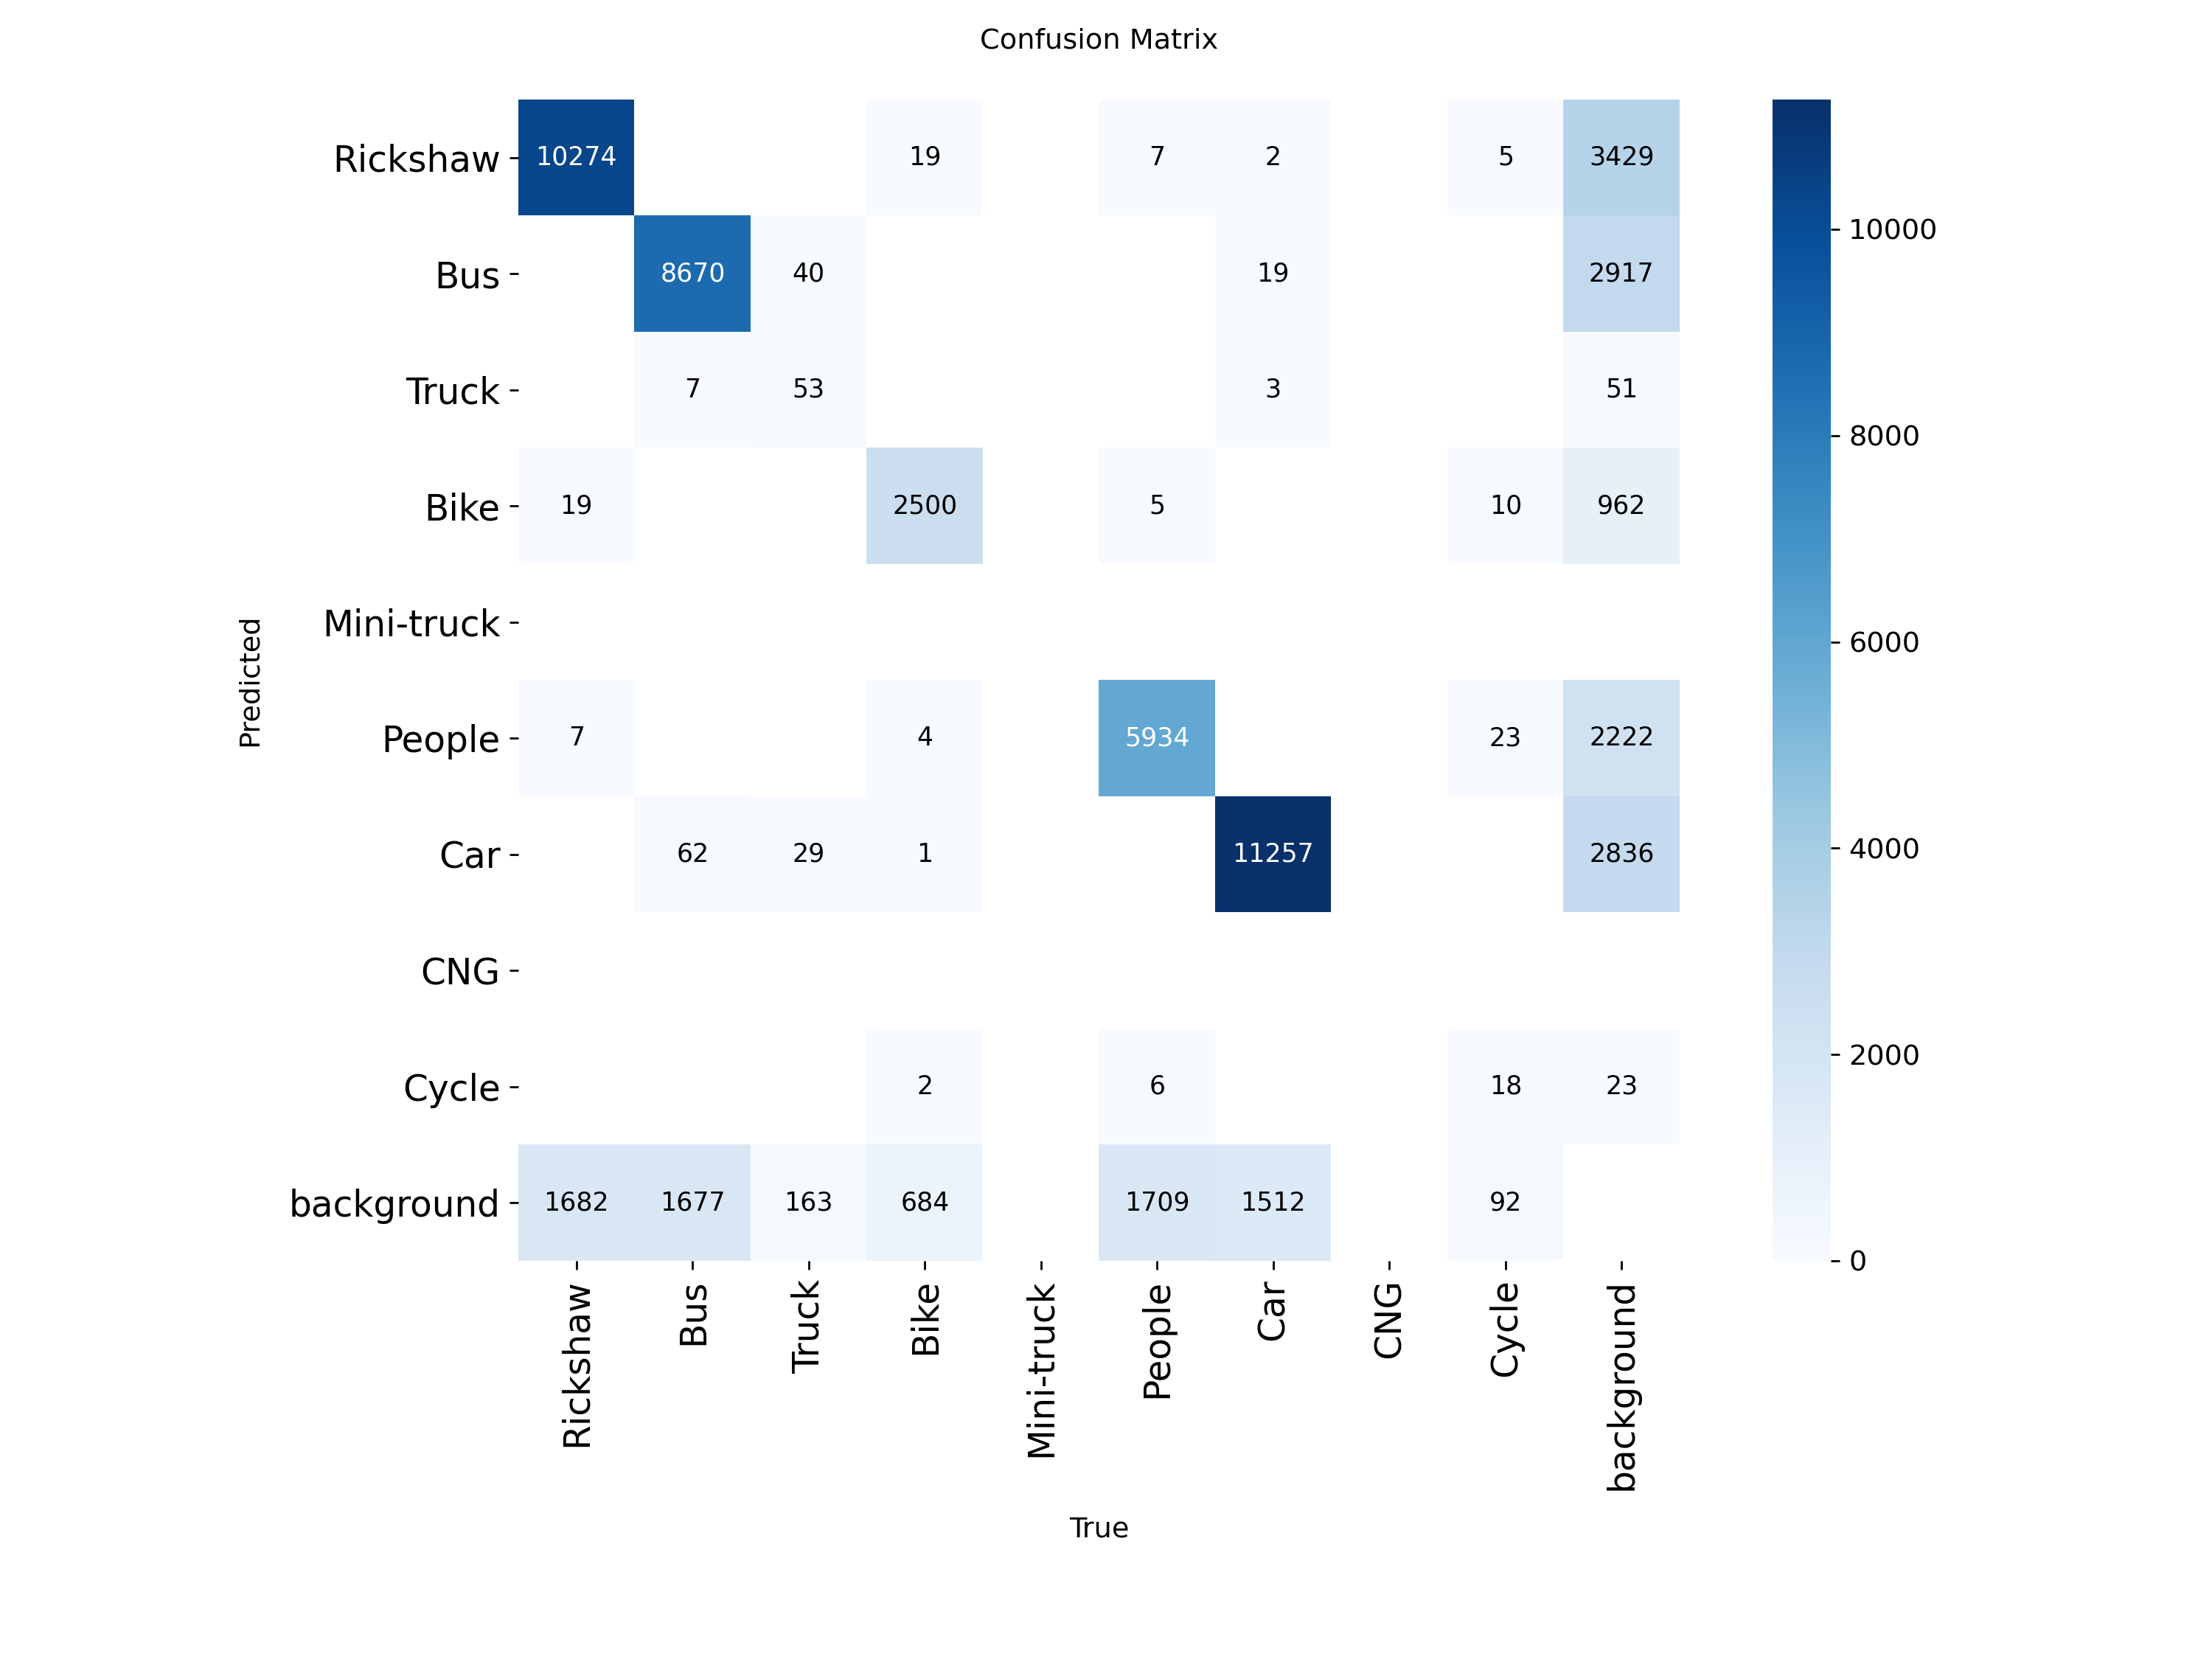

In [9]:
from PIL import Image
from IPython.display import display

WORK = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split") 

results_img = "/kaggle/working/traffic_ssl_vit/simclr_yolov10s/confusion_matrix.png"
img = Image.open(results_img)
display(img)


Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


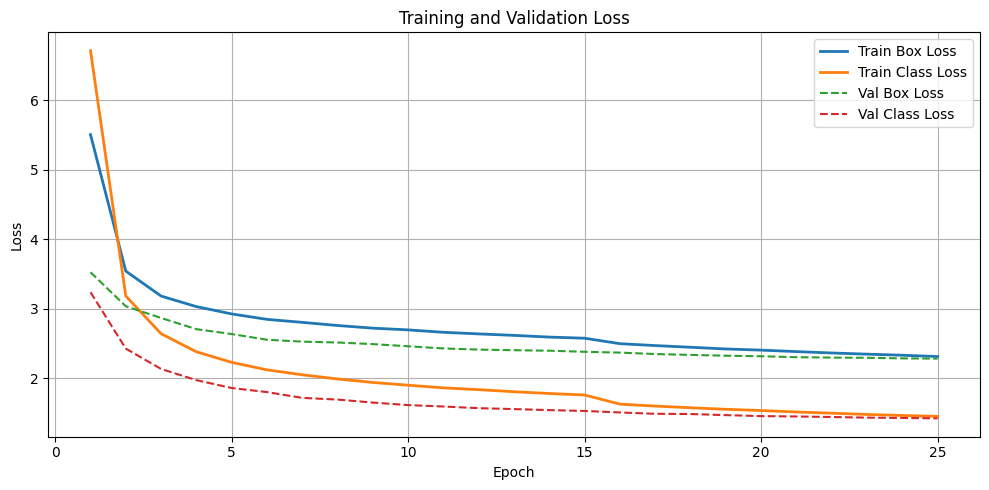

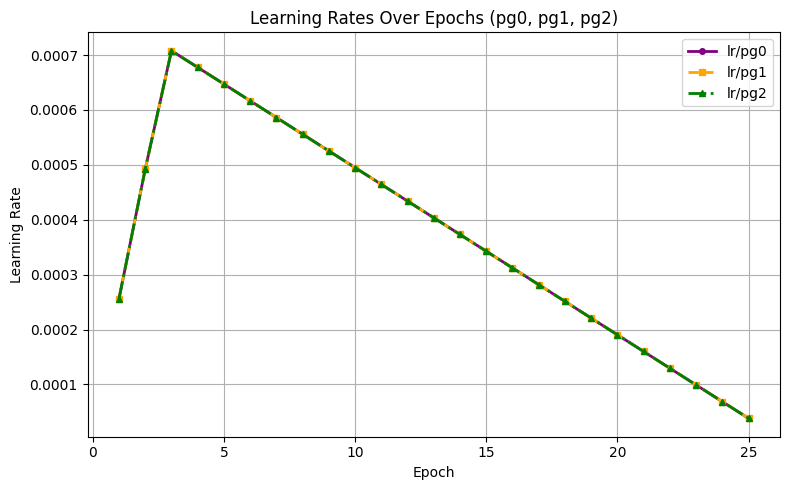

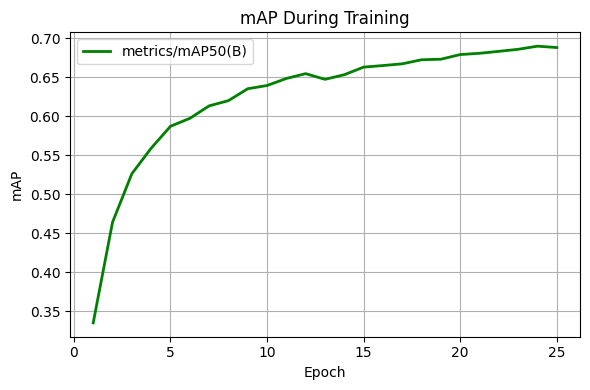

In [10]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

WORK2 = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split") 

# Path to results.csv
results_path = "/kaggle/working/traffic_ssl_vit/simclr_yolov10s/results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")


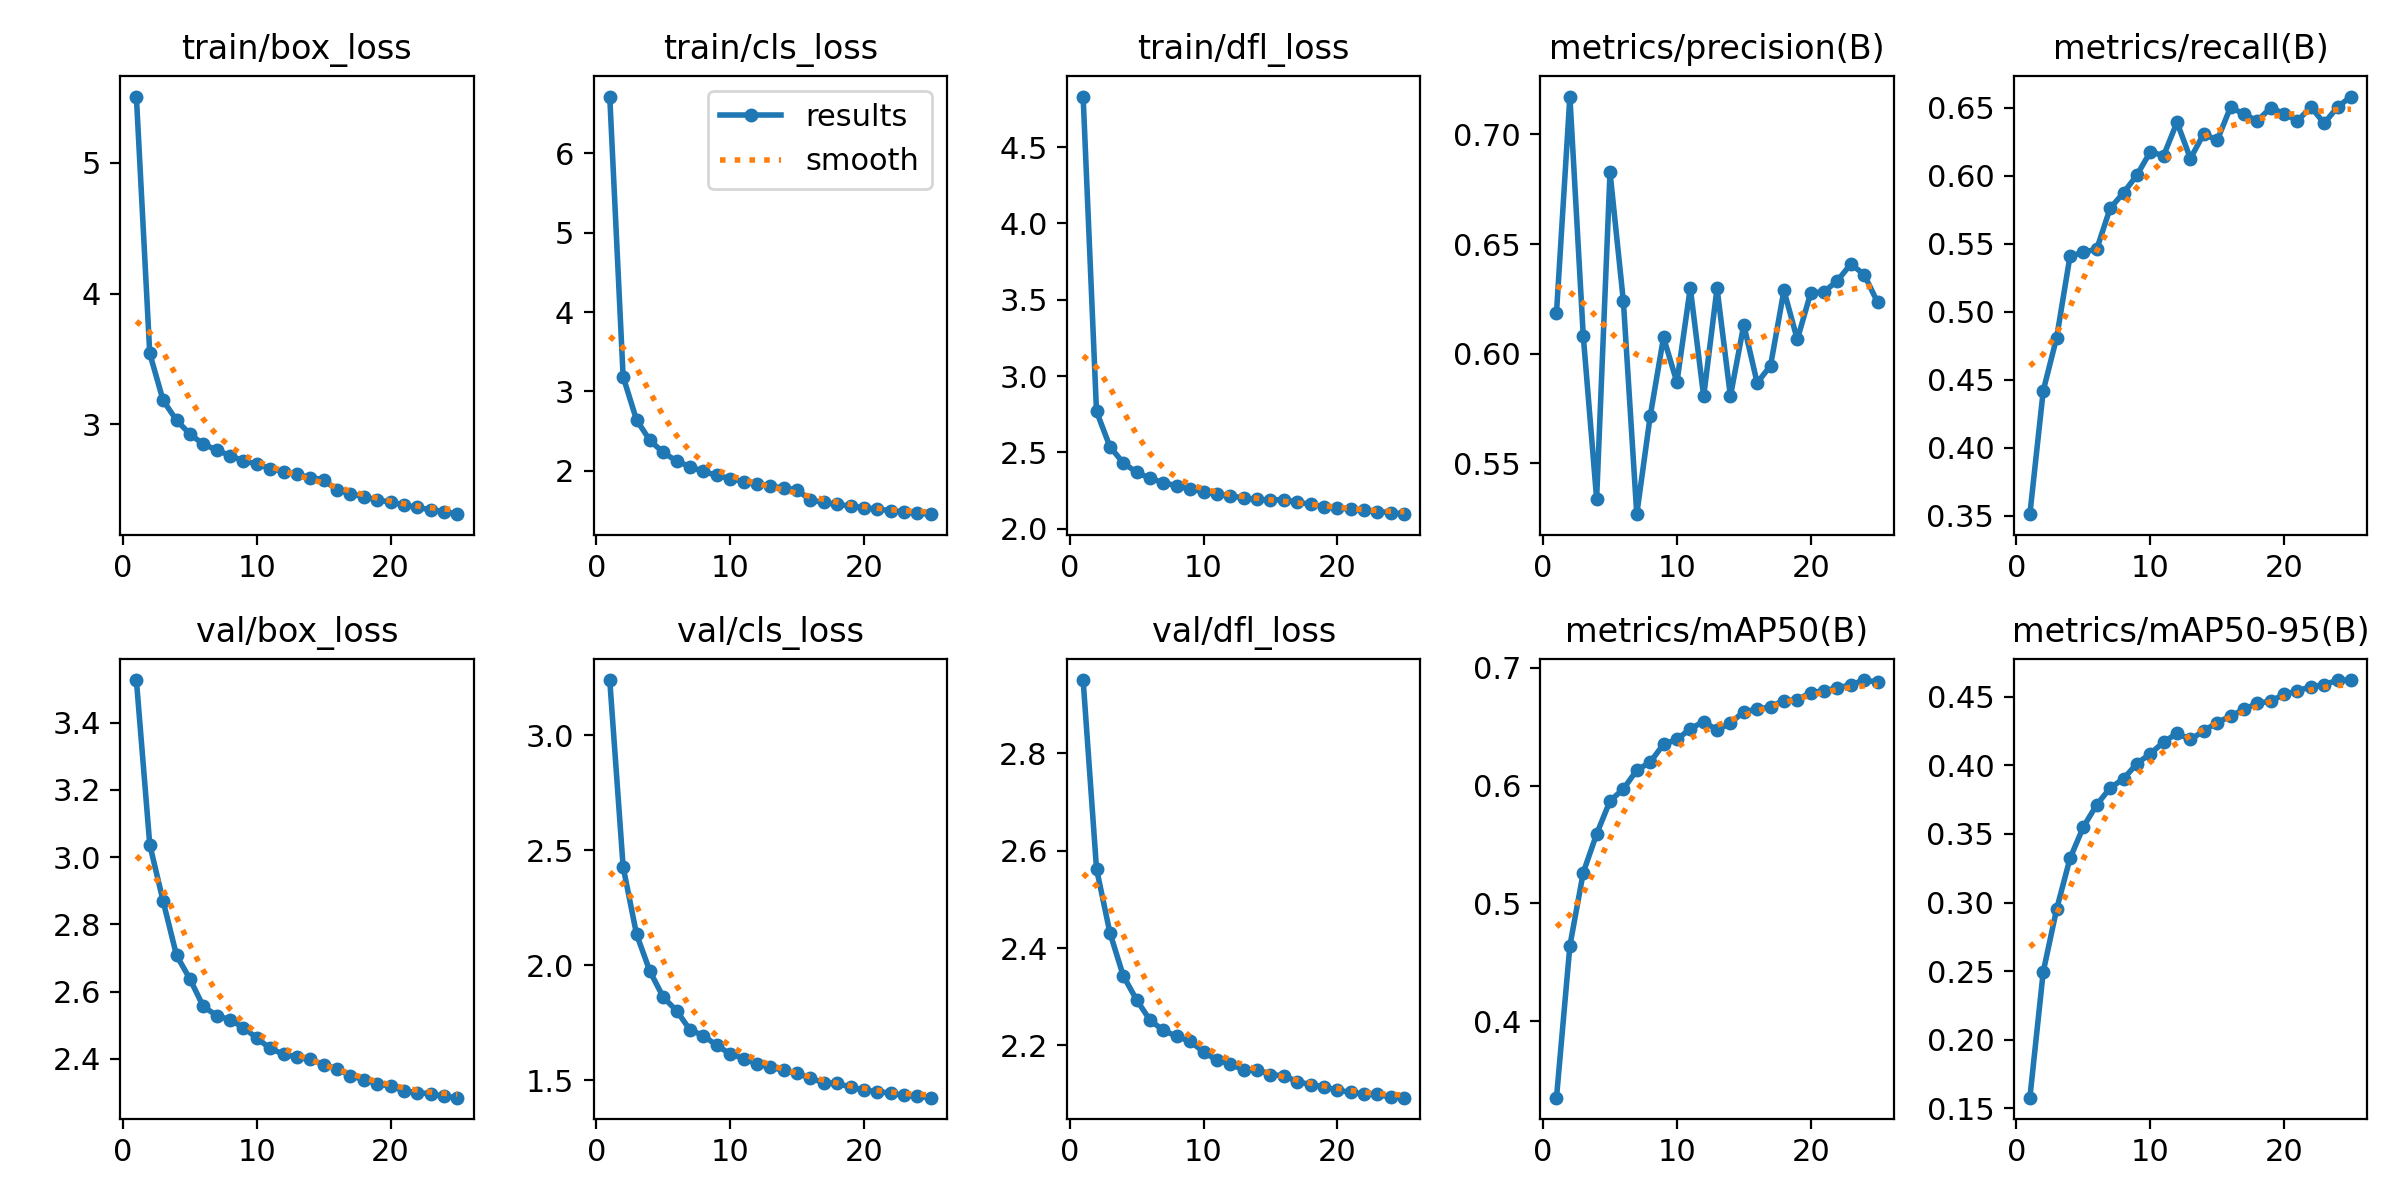

In [11]:
from PIL import Image
from IPython.display import display

results_img = "/kaggle/working/traffic_ssl_vit/simclr_yolov10s/results.png"
img = Image.open(results_img)
display(img)


Ultralytics 8.3.187 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,221,483 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1495.4±599.3 MB/s, size: 64.2 KB)
val: Scanning /kaggle/working/traffic_ssl_vit/0_yolo_split/valid/labels.cache... 4735 images, 13 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4735/4735 9267395.9it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1184/1184 24.4it/s 48.5s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46495      0.636      0.651       0.69      0.462
              Rickshaw       3880      11982      0.728      0.868      0.884        0.6
                   Bus       3868      10416      0.725      0.843      0.857       0.61
                 Truck        267        285      0.451      0.213      0.288      0.221
                  Bike       2127       3210      0.691      0.798      0.812      0.486
                People       2903       7661      0.703      0.794      0.826      0.511
                   Car       4261      12793      0.776       0.89      0.919      0.676
                 Cycle        145        148      0.381      0.149      0.243      0.132
Speed: 0.2ms preprocess, 7.2ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val

Validation metrics
 Precision (mP) : 0.6364
 Recall    (mR) : 0.6506
 mAP@0.50      : 0.6899
 mAP@0.50-0.95 : 0.4623


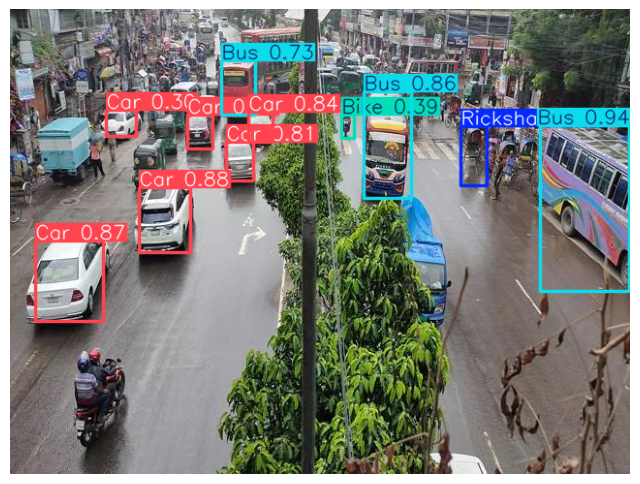

In [12]:
best_pt = "/kaggle/working/traffic_ssl_vit/simclr_yolov10s/weights/best.pt"
model_det = YOLO(str(best_pt))

results = model_det.val(data=str(DATA),
                        imgsz=640,
                        batch=4,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)




WORK3  = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split")
print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")


# visualize a random test image
test_imgs = list((WORK3/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()
else:
    print("No test images found for visualization.")